<h1>Analyze data and build a dashboard with Spark, notebooks, and PixieDust</h1> <br/>

Interactive notebooks are powerful tools for fast and flexible experimentation and data analysis. Notebooks can contain live code, static text, equations and visualizations. 

In this lab, we will walk through how to use PixieDust with Spark and notebooks to:
- Analyze open data around traffic accidents in San Francisco
- Build charts and maps to discover insights

We will then show how to:
- Build a dashboard that drills down into specific areas
- Combine multiple data sources like crime or speeding zones to extract even more insights  

![pixiedust](https://developer.ibm.com/clouddataservices/wp-content/uploads/sites/85/2017/03/pixiedust200.png)

Learn more about PixieDust [Here](https://www.ibm.com/analytics/us/en/watson-data-platform/pixiedust/).

You can access the complete tutorial with step by step instructions here: <a href="https://www.slideshare.net/DTAIEB/pixie-dust-overview" target="_blank" rel="noopener no referrer">PixieDust overview</a>.

This notebook runs on Python with Spark 2.0.

## Table of contents
1. [Install PixieDust](#install)
2. [Import San Francisco traffic accidents data into the notebook](#import)
3. [Explore the data for immediate insights](#explore)
4. [More data exploration and hypothesis](#morexplore)
5. [Focus on the Taraval police district using some friendly SQL notation](#taravalpolice)
6. [Further questions](#furtherquestions)
7. [Build the PixieApp Dashboard](#dashboard)


## 1. Procure PixieDust <a class="anchor" id="install"></a>
Note that DSX Jupyter environment comes with a version of pixiedust already installed

In [1]:
#On a non-DSX notebook, we would install pixiedust with the commands on the following line
#!pip install --upgrade pixiedust

In order ot use the PixieDust library, it must be imported into the notebook.

In [3]:
# This notebook requires version 1.0.6 or higher
import pixiedust

Pixiedust database opened successfully


## 2. Import San Francisco traffic accidents data into the notebook<a class="anchor" id="import"></a>
Source: <a href="https://datasf.org/opendata" target="_blank" rel="noopener no referrer">San Francisco Open Data</a>
> Take a moment to explore all the data available at this site

With PixieDust, you can easily load CSV data from a URL into a PySpark DataFrame in the notebook.   
You will notice that PixieDust will run Spark jobs to get the data into the Spark environment

In [4]:
# With PixieDust, you can easily load CSV data from a URL into a PySpark DataFrame in the notebook.

accidents = pixiedust.sampleData("https://data.sfgov.org/api/views/vv57-2fgy/rows.csv?accessType=DOWNLOAD")

Downloaded 241673 bytes
Creating pySpark DataFrame for 'https://data.sfgov.org/api/views/vv57-2fgy/rows.csv?accessType=DOWNLOAD'. Please wait...
Loading file using 'SparkSession'
Successfully created pySpark DataFrame for 'https://data.sfgov.org/api/views/vv57-2fgy/rows.csv?accessType=DOWNLOAD'


## 3. Interactively Explore the data for immediate insights<a class="anchor" id="explore"></a>

After successfully importing PixieDust and loading the sample data, we can use the `display()` API to quickly browse through and visualize the data to see if we can obtain any immediate insights.

1. Explore the schema and browse the data
   * Select _DataFrame Table_ icon (leftmost htat looks like a grid or table) in the display widget
   * This yields a tabular view of the data. This view can be scrolled through

2. Explore the data graphically to answer questions, e.g. In which police district do the most traffic accidents occur?
   * Choose the _Chart_ icon in the display widget below, select `Pie Chart` type
   * Open the Options and verify that the settings are `Keys=PdDistrict`, `Values=IncidntNum`, `Aggregation=Count`
   * Th eresulting pie chart shows that `Taraval`, `Southern` and `Mission` are the districts where there are most incidents.

3. We can now dig one level deeper by clustering by how each accident was resolved:
   * Choose again _Chart_ icon in the display widget and select `Bar Chart` type
      * Note that you may get an error stating that `bokeh` library is back level, in this case switch the Renderer back to matplotlib (top right drop-down list)
   * Open the options and check that `Keys = PdDistrict`, `Values = IncidntNum`, `Aggregation = Count`
   * On the right side, make sure that the setting is **`Cluster By: Resolution`**
   * We see there that `Taraval` and `Mission` still have the most unresolved incidents, while `Mission` has a relatively better elucidation ratio

4. we can also investigate on what day of the week do the most traffic accidents occur?
   * Choose the _Chart_ icon in the display widget and select `Bar Chart`
   * Change the Options (by drag&drop) so that `Keys = DayOfWeek`, `Values = IncidntNum`, `Aggregation = Count`
   * Set `Cluster By` back to None to get overall figures, wednesday has slightly higher rates
   * Set `Cluster By` to  `PdDistrict` to show by-district figures, where we see that `Taraval` and `Southern` have a spike on Thursdays, while the Wednesday higher average is contributed to mostly by `Bayview` district.

As you can see, PixieDust allows to quickly get insights by interactive graphical data exploration, right out of the Data Science notebook environment, and without extensive beforehand processing of the data.

You may want to explore the possibility of the Display API by watching this <a href="https://www.youtube.com/watch?v=FoOHFlkCaXI" target="_blank" rel="noopener no referrer">Video</a>.


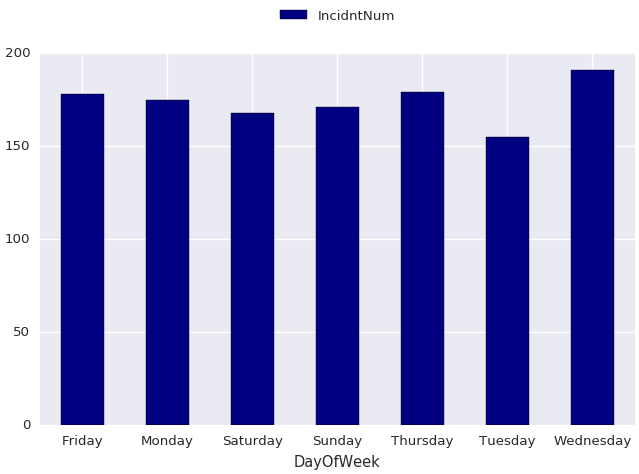

In [6]:
# Invoke PixieDust to propose an initial display of the `accidents` Spark DataFrame
display(accidents)

## 4. More data exploration and hypothesis<a class="anchor" id="moreexplore"></a>
We are able to immediately identify a couple of areas of interest in our data without writing a single line of code:
- Most accidents happen in the Southern and Taraval police districts
- Most accidents happen on Wednesdays and Thursdays

Now, the advantage of running this visual exploration from withing the Data Science environment is that it allows to quickly decide and apply further data processing and refinement to drill-down into more analysis.

Do go a step further, We can also see that our data needs some cleansing if we want to make analysis easier. Specifically:
- The `Time` field is a string, so we'll need to add an `Hour` column if we want to see the time of day when most accidents occur
- The `DayOfWeek` values are rendered in alphabetical order by default instead of chronological order, so we should rename them to make it easier to see how the number of accidents changes over the course of the week
- We should condense the outcome types of each traffic accident if we want to see the most common resolutions of traffic accidents in each police district, because the clustering above was unclear

Let's cleanse the data and re-investigate before moving on:

**Note**: the next cell is using PySpark APIs to manipulate the data. You can find more information on these APIs <a href="http://spark.apache.org/docs/1.6.0/api/python/pyspark.sql.html" target="_blank" rel="noopener no referrer">here</a>.

In [7]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

# Get the hour value of a time string
# e.g. getHour("05:30") = 5
def getHour(s):
    return int(s.split(':')[0])

hr_udf = udf(getHour,IntegerType())

# Rename weekdays to enable mini time-series analysis
accidents = accidents.na.replace\
    (['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],\
    ['1-Mon','2-Tues','3-Wed','4-Thur','5-Fri','6-Sat','7-Sun'],\
    'DayOfWeek')

# Add Hour column and refine outcomes from traffic accidents
accidents = accidents.withColumn("Hour",hr_udf(accidents['Time']))\
    .withColumn("Res",\
    udf(lambda x: 'Arrest' if 'ARREST' in x else 'No Resolution' if x == 'NONE' else 'Other',StringType())\
    (accidents['Resolution']))


### We are now ready for more data exploration
1. Hypothesis: Do accidents in one police district result in more arrests than other police districts?
    * To find out, run the cell below and set the following display options:
    * Bar Chart
    * _Options_: `Keys = PdDistrict`, `Values = IncidntNum`, `Aggregation = Count`, `Cluster By: Res`
    * The districts where there are more arrests than no resolution stand out (`Richmnond`, `Mission`, ...)

2. Question: How does the number of accidents change over the course of the week?
    * To answer, change the options to 
    * Line Chart
    * _Options: `Keys = DayOfWeek`, `Values = IncidntNum`, `Aggregation = Count`,  `Cluster By: None`
    * as in the previous graph, Wednesday stands out, but we see a decrease until Sunday


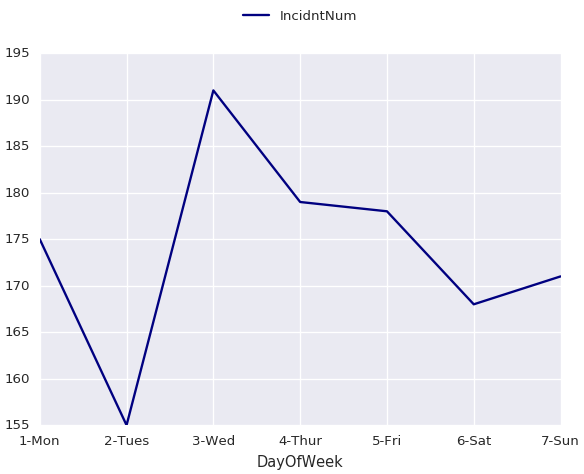

In [8]:
display(accidents)

### What have we learned
A few lines of code makes it a lot easier to see that:

- Accidents in the Mission police district are much more likely to result in arrest than all other districts

- The number of accidents peaks during the middle of the week, but decreases afterwards as the week winds down

## 5. Focus on the Taraval police district using some friendly SQL notation<a class="anchor" id="taravalpolice"></a>
We will now use the power of Spark SQL to run familiar syntax SQL queries on the Spark DataFrames   
First we need to register the dataset under a name to use as SQL tablename   
Since we want to refine exploration to `Taraval`, we will extract the subset and display it using PixieDust

In [10]:
accidents.registerTempTable("accidents")
taraval = sqlContext.sql("SELECT * FROM accidents WHERE PdDistrict='TARAVAL'")

### Run the cell below to display a Taraval-focused map
We are now able to drill down deeper in the structure of `Taraval` incidents
1. Question: Where in Taraval do most accidents happen?
   * Select `Map` as type (we have x,y coordinates for incidents locations)
   * Set Options to  `Keys = [X,Y]`, `Values = IncidntNum`, `Aggregation = Count`
   * Set the Renderer to `mapbox`, kind: chloropleth-cluster
   * It appears that incidents are pretty much evenly distributed within the district, outside of lake and hills areas with a slight predominance of south-west, and mostly on main thoroughfares

2. Question: What time of day do most accidents occur?
   * select type back to `Line Chart`
   * Set Options: `Keys = Hour`, `Values = IncidntNum`, `Aggregation = Count`
   * The spike of incidents clearly matches the 2pm-3pm time slot 


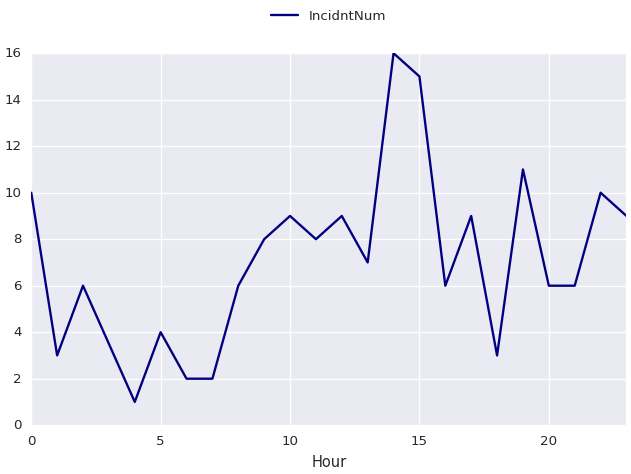

In [11]:
display(taraval)

### What have we learned
Most of the results from looking at the accident times are unsurprising:

- Fewer accidents during very early morning (people probably sleeping)
- Steady increase in number of accidents during morning commuting hours
- Fewer accidents during mid-evening (people probably eating dinner)
- (Sadly) more accidents late at night

The interesting thing here is the sudden spike in accidents during mid-afternoon (2-3PM) - twice as many accidents happen during this two-hour window!

## 6. Further questions<a class="anchor" id="furtherquestions"></a>

In analyzing the geographical data, we can see a couple of clusters where accidents occur more frequently in Taraval - the southeastern corner looks particularly crowded. Some useful questions to ask at this point are:

**- Does crime have an effect on the number of accidents?**

**- Are there more accidents in these areas because more people speed there?**

**- Do traffic calming devices reduce the number of accidents?**

A Data Scientist would test these hypotheses by downloading datasets for speeding data and traffic calming in San Francisco, join this to the existing data through Spark DataFrame work, and use the `display` API to visualize speeding zones and areas with traffic calming devices separately